# DGL ことはじめ
**DGL (Deep Graph Library)** は、Pytorch や MXNet のような既存のテンソルを扱う深層学習フレームワーク上に構築される、グラフ上の視認速学習のための Python パッケージで、グラフ ニューラルネットワークの実装を簡単に行うことが出来ます。

[Overview of DGL — DGL 0.4 documentation](https://docs.dgl.ai/index.html)

このチュートリアルでは、以下を目的としています。

* DGL がどのようにグラフ上の計算を可能とするのかざっくりと知る
* グラフノードを分類するための、シンプルなグラフニューラルネットワークを DGL で学習する

チュートリアルを完了すれば、DGL がどんなふうに利用できるのか簡単に感じることができるでしょう。
なお、本チュートリアルは、基礎的な PyTorch の使い方を知っている人を対象とします。

## チュートリアルの問題の説明
このチュートリアルは、「ザカリーの空手クラブ」問題に基づいています。空手クラブは、34人のメンバーを含むソーシャルネットワークであり、クラブ外で交流するメンバー間のペアワイズリンクを文書化します。クラブは後に、インストラクター（ノード0）とクラブ会長（ノード33）が率いる2つのコミュニティに分かれます。ネットワークは次のように視覚化され、色はコミュニティを示します。

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/img/karate-club.png)

ソーシャルネットワークを考慮して、各メンバーが参加する傾向があるクラス（0または33）を予測するのが、今回のタスクです。

## ステップ1: DGL でグラフを作成する

空手クラブのグラフは次のように作成出来ます。

In [1]:
import dgl

def build_karate_club_graph():
    g = dgl.DGLGraph()
    
    # g.add_nodes([v for v in range(34)) と同じです
    g.add_nodes(34)

    # karate club network
    edge_list = [
        (1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]

    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    g.add_edges(dst, src)

    return g

作成したグラフとエッジの数を表示します。

In [2]:
G = build_karate_club_graph()

print(G.number_of_edges())
print(G.number_of_nodes())

156
34


`networkx` でグラフを可視化します。

グラフを 2 次元に描写するには、各ノードに x, y 座標を付与しなければなりません。。
人間にとって美しいと感じるようなグラフの描写アルゴリズム (座標計算アルゴリズム) の一つに、力学モデルによるグラフ描写と呼ばれる方法が存在します。

- [力学モデル (グラフ描画アルゴリズム) - Wikipedia](https://ja.wikipedia.org/wiki/%E5%8A%9B%E5%AD%A6%E3%83%A2%E3%83%87%E3%83%AB_(%E3%82%B0%E3%83%A9%E3%83%95%E6%8F%8F%E7%94%BB%E3%82%A2%E3%83%AB%E3%82%B4%E3%83%AA%E3%82%BA%E3%83%A0))

`networkx` の `kamada_kawai_layout` 関数は、Kamada-Kawai アルゴリズムと呼ばれる力学モデル アルゴリズムの実装です。ノードが対称的にちらばった、均衡状態の座標を計算することが出来ます。

- [An algorithm for drawing general undirected graphs - ScienceDirect](https://www.sciencedirect.com/science/article/pii/0020019089901026)
- [Kamada-Kawaiのアルゴリズム - terablog](http://tera-kun.hatenadiary.com/entry/2017/05/19/005307)

nx version: 2.4


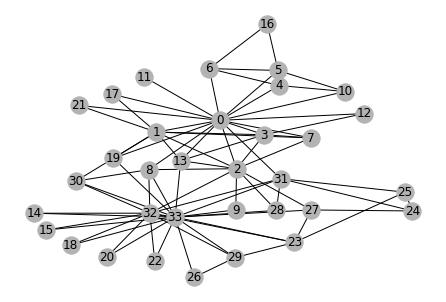

In [3]:
import networkx as nx
print('nx version:', nx.__version__)

nx_G = G.to_networkx().to_undirected()

pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7,.7,.7]])

## ステップ2: ノード/エッジに特徴量を割り当てる

GNN (グラフ ニューラル ネットワーク) の学習のために、ノードとエッジに特徴量を与えます。

分類の例では、各ノードに入力特徴として one-hot vector の ID 特徴を割り当てます。例えば、$v_i$ の特徴ベクトルは、$(0, \dots, 0, 1, 0, \dots, 0)^\top$ となります。

DGL では、最初の次元に従ってノード特徴を処理するテンソルを利用するので、すべてのノードの特徴量を行列として与えます。

In [4]:
import torch
print('torch.__version__:', torch.__version__)

G.ndata['feat'] = torch.eye(34)

torch.__version__: 1.4.0


In [5]:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

# print out node 10 and 11's input features
print(G.nodes[[10, 11]].data['feat'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


## ステップ 3: グラフ畳み込みネットワーク (GCN) レイヤーを定義する

ノード分類の実行に、(Kipf and Welling 2017) による **GCN (Graph Convolutional Network)** レイヤーを利用します。

- [[1609.02907] Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907)
- [Graph Convolutional Networks | Thomas Kipf | PhD Student @ University of Amsterdam](https://tkipf.github.io/graph-convolutional-networks/)

GCN はレイヤーとして定義され、ちょうど CNN の畳み込みレイヤーのようにニューラルネットワーク内部で機能します。GCN レイヤーの目的は、各ノードの潜在特徴 $\mathbf{h}_v$ を更新することです。

簡単に図式化すると次のようなイメージです。

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/1_first/mailbox.png)




In [6]:
import torch.nn as nn
import torch.nn.functional as F

def gcn_message(edges):
    """近傍ノードの特徴量 h_j をどのように中心ノードに運ぶかを定義する関数

    GCN の論文では近傍数に応じた正規化項 c_v で除算しているが、このチュートリアルでは省略。
    """
    return {'msg': edges.src['h']}

def gcn_reduce(nodes):
    """gcn_message で収集した特徴量をどのように集約するかを定義する関数
    
    """
    return {'h': torch.sum(nodes.mailbox['msg'], dim=1)}


class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # input に渡した行列を、h の初期値とする
        g.ndata['h'] = inputs
        # メッセージの送信と集約 (h の作成)
        g.send(g.edges(), gcn_message)
        g.recv(g.nodes(), gcn_reduce)
        # g.ndata には集約後の h が保存されているので、取り出す
        h = g.ndata.pop('h')
        # 最後にアフィン変換して出力
        return self.linear(h)

上で定義した GCN レイヤーを 2 層含む GCN モデルを定義します。

In [7]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h

# gcn1 で、one-hot encoding のインデクス特徴量 (34 x 34 の行列) が、hidden_size = 5 の特徴量 (34x5 行列) に変換される
# gcn2 で、hidden 特徴量 (34x5 行列) が、num_classes = 2 の行列 (34x2 行列) に変換される
# 出力はあくまで実数行列なので、分類タスクの文脈では「ロジット」として解釈される値を含んだ行列である点に注意
net = GCN(34, 5, 2)

## ステップ 4: データの準備と初期化

半教師あり学習の分類タスク (semi-supervised classification) を行います。簡単に言うと、一部のノードしかカテゴリがわかっていない状態で、残りのノードのカテゴリも予測するタスクです。より詳しくは：

- **入力 (given)**:
    - グラフ構造 $G = (V, E)$
    - 各ノードの特徴量 $\mathbf{X}_v \in \mathbb{R}^d$
    - ラベル空間 $\mathcal{Y}$
    - ノードの部分集合 $S$ に対するラベル $(v_k, y_k \in \mathcal{Y})_{v_k \in S} $
- **目的 (goal)**: 
    - 残りのノード $V\setminus S$ に対するラベルを出力する

ここでは、one-hot vecotr を利用してノードの特徴量 $\mathbf{X}_v$ を与え、superviser としてはノード ID が `0, 33` のものを使います。もちろんラベル空間はバイナリ空間 $\mathcal{Y} = \{ 0,1 \}$ です。

In [8]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])
labels = torch.tensor([0, 1])

## ステップ 5: 訓練と視覚化

訓練の方法は PyTorch の通常の NN と同じです。つまり、

1. `optimizer` を作成
2. モデルに入力を与えて推論
3. 目的関数 (損失) を計算
4. autograd を利用して SGD によるパラメータ更新

という手順で学習を行います。

In [9]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

all_logits = []
for epoch in range(50):
    # forward の計算
    logits = net(G, inputs)

    # ロジットの記録
    all_logits.append(logits.detach())

    # 損失の計算
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels)

    # SGD
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.7024
Epoch 1 | Loss: 0.6304
Epoch 2 | Loss: 0.5694
Epoch 3 | Loss: 0.5116
Epoch 4 | Loss: 0.4479
Epoch 5 | Loss: 0.3786
Epoch 6 | Loss: 0.3083
Epoch 7 | Loss: 0.2394
Epoch 8 | Loss: 0.1782
Epoch 9 | Loss: 0.1267
Epoch 10 | Loss: 0.0867
Epoch 11 | Loss: 0.0577
Epoch 12 | Loss: 0.0374
Epoch 13 | Loss: 0.0238
Epoch 14 | Loss: 0.0149
Epoch 15 | Loss: 0.0093
Epoch 16 | Loss: 0.0058
Epoch 17 | Loss: 0.0037
Epoch 18 | Loss: 0.0024
Epoch 19 | Loss: 0.0015
Epoch 20 | Loss: 0.0010
Epoch 21 | Loss: 0.0007
Epoch 22 | Loss: 0.0005
Epoch 23 | Loss: 0.0003
Epoch 24 | Loss: 0.0003
Epoch 25 | Loss: 0.0002
Epoch 26 | Loss: 0.0001
Epoch 27 | Loss: 0.0001
Epoch 28 | Loss: 0.0001
Epoch 29 | Loss: 0.0001


以上はトイ サンプルに過ぎないので、検証データやテストデータすら用意していません。

その代わり、ロジットを 2 つ出力するので (無理やりではありますが) x, y 座標とみなすと 2 次元に図式化することが出来ます。

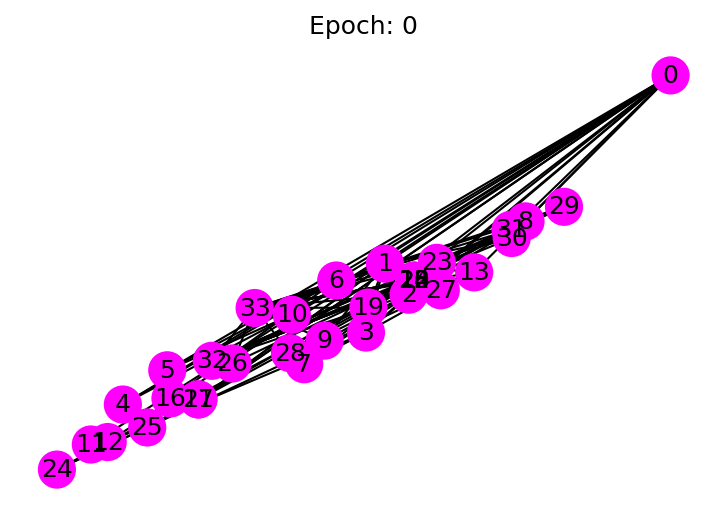

In [15]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

%matplotlib inline

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch
plt.show()

In [22]:
![ -d output ] || mkdir output

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


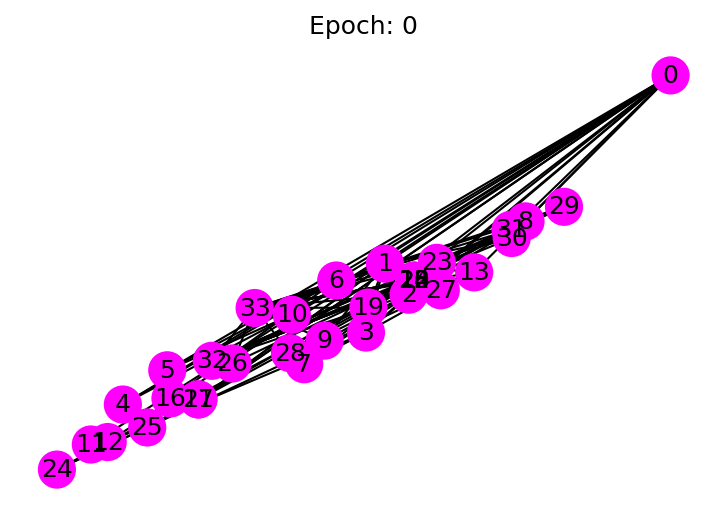

In [23]:
fig, ax = plt.subplots(dpi=150)
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
ani.save("./output/karate-club-semi-supervised.gif", writer="imagemagick")

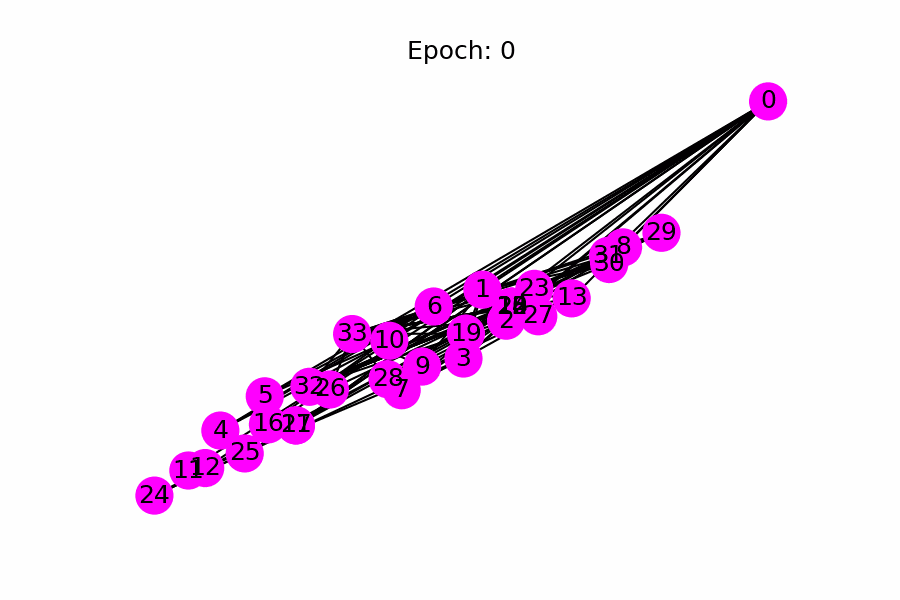

In [24]:
from IPython.display import Image
Image(filename="./output/karate-club-semi-supervised.gif")